## QAOA Ansatz Comparison: Vanilla, Free, and Orbit

This notebook compares three QAOA ansätze on the **house graph** (5 nodes, 6 edges).

| Ansatz | Problem | Mixer | γ / layer | β / layer |
|--------|---------|-------|-----------|----------|
| **Vanilla** | `MaxCut` | `X` | 1 | 1 |
| **Free** | `MaxCutFree` | `XMultiAngle` | E (one per edge) | N (one per node) |
| **Orbit** | `MaxCutOrbit` | `XOrbit` | K_E (one per edge orbit) | K_N (one per node orbit) |

### Definitions

- **Vanilla QAOA** uses a single shared γ for all edges and a single β for all nodes. It is the original QAOA proposal.

- **Free QAOA** (multi-angle) maximises the number of independent parameters: each edge gets its own γ and each node gets its own β. There is no parameter sharing whatsoever.

- **Orbit QAOA** (following [arXiv:2410.05187](https://arxiv.org/abs/2410.05187)) exploits the automorphism group Aut(G) of the graph to construct an *equivariant* ansatz. Edges related by a graph automorphism share one γ, and nodes related by a graph automorphism share one β.

### Optimisation strategy

At depth p=1, a **2-D grid search** over (γ, β) is performed using the *vanilla (symmetric) subspace*: all gamma parameters for the layer are set equal to the grid γ value and all beta parameters to the grid β value. This gives the same warm-start landscape as vanilla QAOA regardless of how many parameters the ansatz has.

At depth p>1, the **interpolation heuristic (INTERP)** works well for vanilla QAOA but gives non-monotonic approximation ratios for free/orbit ansätze. Instead, free and orbit use a **layer-by-layer grid search** (`interpolate=False`): the best parameters from depth p−1 are *locked*, and a new 2-D grid search is performed over the new layer's parameters (again in the vanilla subspace). Because the grid includes (γ=0, β=0), which adds an identity layer and reproduces the depth-(p−1) result, the search guarantees `cost(p) ≤ cost(p−1)`, ensuring a **monotonically increasing approximation ratio**.

In [1]:
from qaoa import QAOA, problems, mixers, initialstates

In [2]:
import numpy as np
import networkx as nx
import sys
import matplotlib.pyplot as plt

sys.path.append("../")
from plotroutines import *

### Graph

Choose:
- *house graph* has 5 nodes and 6 edges
- *Erdős–Rényi* has 10 nodes and 16 edges
- *random regular*

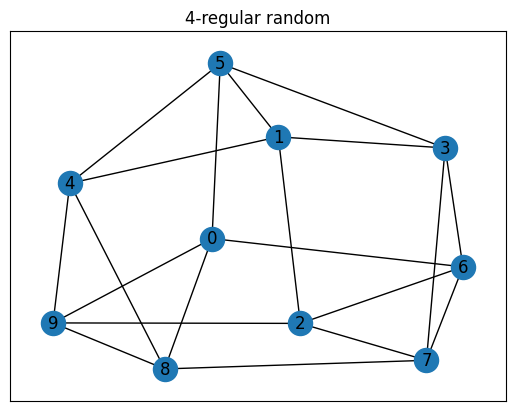

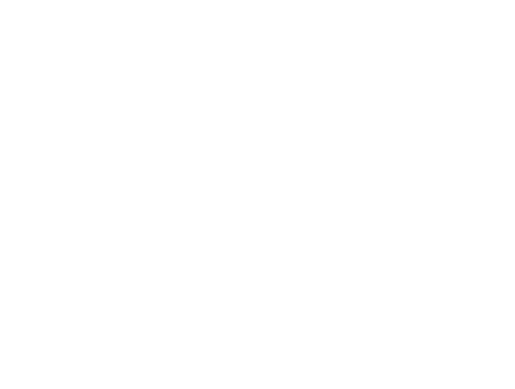

Nodes: [4, 9, 3, 7, 8, 0, 5, 1, 6, 2]
Edges: [(4, 9), (4, 5), (4, 8), (4, 1), (9, 8), (9, 0), (9, 2), (3, 7), (3, 1), (3, 6), (3, 5), (7, 2), (7, 6), (7, 8), (8, 0), (0, 5), (0, 6), (5, 1), (1, 2), (6, 2)]


In [3]:
mode = "regular"   # options: "house", "er", "regular"

if mode == "house":
    G = nx.house_graph()
    pos = {0: (0, 0), 1: (1, 0), 2: (0, 1), 3: (1, 1), 4: (0.5, 2)}
    nx.draw_networkx(G, pos=pos)
    plt.title("House graph")

elif mode == "er":
    G = nx.read_gml("data/er_n10_k4_0.gml")
    nx.draw_networkx(G)
    plt.title("Erdős–Rényi graph")

elif mode == "regular":
    G = nx.random_regular_graph(4, 10)
    nx.draw_networkx(G)
    plt.title("4-regular random")

plt.show()

plt.axis("off")
plt.show()

print(f"Nodes: {list(G.nodes())}")
print(f"Edges: {list(G.edges())}")

### Optimal Max Cut

Brute-force the minimum QAOA cost (= maximum cut value) for reference.

In [4]:
problem_ref = problems.MaxCut(G)
mincost, maxcost = problem_ref.computeMinMaxCosts()

### Graph Symmetry Analysis

The orbit QAOA uses the automorphism group Aut(G) to assign shared parameters.
Below we display the **node orbits** (for the β mixer parameters) and **edge orbits** (for the γ problem parameters).

In [5]:
orbit_problem = problems.MaxCutOrbit(G)
orbit_mixer  = mixers.XOrbit(G)

print(f"Node orbits ({len(orbit_mixer.node_orbits)} total):")
for i, orb in enumerate(orbit_mixer.node_orbits):
    print(f"  β_{i}: nodes {orb}")

print()
print(f"Edge orbits ({len(orbit_problem.edge_orbits)} total):")
for i, orb in enumerate(orbit_problem.edge_orbits):
    print(f"  γ_{i}: edges {orb}")

Node orbits (5 total):
  β_0: nodes [0, 2]
  β_1: nodes [1, 5]
  β_2: nodes [3, 9]
  β_3: nodes [4, 6]
  β_4: nodes [7, 8]

Edge orbits (11 total):
  γ_0: edges [(9, 4), (3, 6)]
  γ_1: edges [(9, 5), (3, 1)]
  γ_2: edges [(9, 8), (3, 7)]
  γ_3: edges [(9, 1), (3, 5)]
  γ_4: edges [(4, 8), (7, 6)]
  γ_5: edges [(4, 0), (6, 2)]
  γ_6: edges [(4, 2), (0, 6)]
  γ_7: edges [(7, 2), (8, 0)]
  γ_8: edges [(7, 8)]
  γ_9: edges [(0, 5), (1, 2)]
  γ_10: edges [(5, 1)]


In [6]:
from qaoa.initialstates import InitialState
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
class Ones(InitialState):
    def __init__(self) -> None:
        super().__init__()

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)
        self.circuit.x(q)

### Create QAOA Instances

Three instances with different parameter budgets per layer.

- **Vanilla**: `interpolate=True` (default) — INTERP heuristic for p>1.
- **Free / Orbit**: `interpolate=False` — layer-by-layer grid search for p>1, guaranteeing monotonically increasing approximation ratio.

In [7]:
# Vanilla: one shared γ and one shared β; INTERP heuristic for p>1
qaoa_vanilla = QAOA(
    problem=problems.MaxCut(G),
    mixer=mixers.X(),
    initialstate=initialstates.Plus(),
    interpolate=True,
)

# Free: one γ per edge, one β per node; layer grid search for p>1
qaoa_free = QAOA(
    problem=problems.MaxCutFree(G),
    mixer=mixers.XMultiAngle(),
    initialstate=Ones(),
    interpolate=False,  # layer-by-layer grid search
)

# Orbit: one γ per edge orbit, one β per node orbit; layer grid search for p>1
qaoa_orbit = QAOA(
    problem=problems.MaxCutOrbit(G),
    mixer=mixers.XOrbit(G),
    initialstate=Ones(),
    interpolate=False,  # layer-by-layer grid search
)

# Build circuits at depth 1 to inspect parameter counts
for q in (qaoa_vanilla, qaoa_free, qaoa_orbit):
    q.createParameterizedCircuit(depth=1)

print(f"Vanilla — γ/layer: {qaoa_vanilla.n_gamma},  β/layer: {qaoa_vanilla.n_beta}")
print(f"Free    — γ/layer: {qaoa_free.n_gamma}  (1 per edge),  β/layer: {qaoa_free.n_beta} (1 per node)")
print(f"Orbit   — γ/layer: {qaoa_orbit.n_gamma}  (1 per edge orbit), β/layer: {qaoa_orbit.n_beta} (1 per node orbit)")

Vanilla — γ/layer: 1,  β/layer: 1
Free    — γ/layer: 20  (1 per edge),  β/layer: 10 (1 per node)
Orbit   — γ/layer: 11  (1 per edge orbit), β/layer: 5 (1 per node orbit)


### Energy Landscape at Depth 1 (Vanilla)

Sample the cost landscape over the (γ, β) grid for the vanilla instance.  
The grid search uses the vanilla (symmetric) subspace, so the best grid point
is a valid warm-start for all three ansätze.

2026-02-27 11:24:41 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2026-02-27 11:24:41 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2026-02-27 11:24:41 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2026-02-27 11:24:41 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2026-02-27 11:24:45 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2026-02-27 11:24:45 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


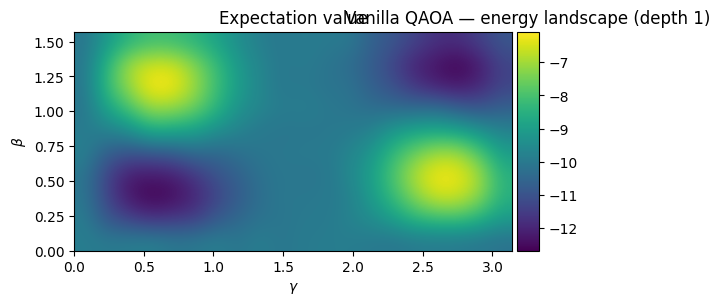

In [8]:
angles = {"gamma": [0, np.pi, 20], "beta": [0, np.pi/2, 10]}
qaoa_vanilla.sample_cost_landscape(angles=angles)

fig = plt.figure(figsize=(6, 5))
plot_E(qaoa_vanilla, fig=fig)
plt.title("Vanilla QAOA — energy landscape (depth 1)")
plt.show()

### Run Optimisation

Optimise all three ansätze up to `maxdepth = 5`.

- **Vanilla**: p=1 grid search → INTERP for p>1.
- **Free / Orbit**: p=1 grid search (vanilla subspace) → layer-by-layer grid search for p>1 (locks previous layers, searches new layer, then frees all params for local opt).

In [9]:
maxdepth = 5

qaoa_vanilla.optimize(depth=maxdepth)
qaoa_free.optimize(depth=maxdepth, angles=angles)
qaoa_orbit.optimize(depth=maxdepth, angles=angles)

2026-02-27 11:24:46 [info     ] cost(depth 1 = -12.6640625     file=qaoa.qaoa func=optimize
2026-02-27 11:24:48 [info     ] cost(depth 2 = -13.753906249999998 file=qaoa.qaoa func=optimize
2026-02-27 11:24:50 [info     ] cost(depth 3 = -14.435546875000009 file=qaoa.qaoa func=optimize
2026-02-27 11:24:54 [info     ] cost(depth 4 = -14.929687500000002 file=qaoa.qaoa func=optimize
2026-02-27 11:24:59 [info     ] cost(depth 5 = -15.2578125     file=qaoa.qaoa func=optimize
2026-02-27 11:24:59 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2026-02-27 11:24:59 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2026-02-27 11:24:59 [info     ] parameters: 30                 file=qaoa.qaoa func=sample_cost_landscape
2026-02-27 11:24:59 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2026-02-27 11:25:02 [info     ] Done measurement               file=qaoa.qaoa func=sample_co

### Compare Approximation Ratios

Free and orbit should show a **monotonically increasing** approximation ratio
thanks to the layer-by-layer grid search initialisation strategy.

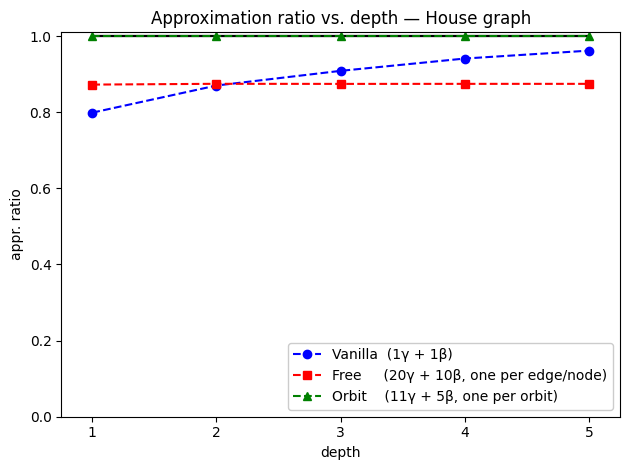

In [10]:
fig = plt.figure()

plot_ApproximationRatio(
    qaoa_vanilla, maxdepth,
    mincost=mincost, maxcost=maxcost,
    label=f"Vanilla  (1γ + 1β)",
    style="o--b",
    fig=fig,
)
plot_ApproximationRatio(
    qaoa_free, maxdepth,
    mincost=mincost, maxcost=maxcost,
    label=f"Free     ({qaoa_free.n_gamma}γ + {qaoa_free.n_beta}β, one per edge/node)",
    style="s--r",
    fig=fig,
)
plot_ApproximationRatio(
    qaoa_orbit, maxdepth,
    mincost=mincost, maxcost=maxcost,
    label=f"Orbit    ({qaoa_orbit.n_gamma}γ + {qaoa_orbit.n_beta}β, one per orbit)",
    style="^--g",
    fig=fig,
)

plt.title("Approximation ratio vs. depth — House graph")
plt.tight_layout()
plt.show()

### Optimal Angles at Maximum Depth (Vanilla)

`plot_angles` expects the 1 γ + 1 β per-layer format, so we display it only for the vanilla ansatz.

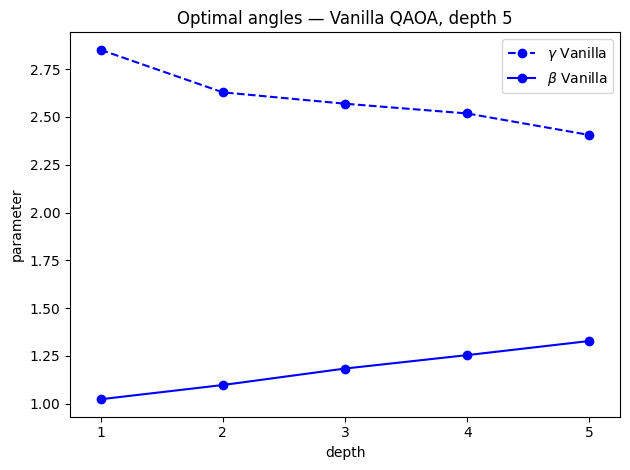

In [11]:
fig = plt.figure()
plot_angles(qaoa_vanilla, maxdepth, label="Vanilla", style="ob", fig=fig)
plt.title(f"Optimal angles — Vanilla QAOA, depth {maxdepth}")
plt.tight_layout()
plt.show()